# CNN Base分类器

## 库导入

In [1]:
import sys
import time
import os
import re
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import keras as kr


# 实时更新进度条
def print_flush(print_string):
    print(print_string, end='\r')
    sys.stdout.flush()

# 获取显存动态增长的会话 
def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

# 选择数据集及分类器，0 - THUCNews，1 - 今日头条
predictor_set = ["THUCNews", "TouTiao"]
name_of_predictor = predictor_set[1]

Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow backend.


## 导入数据

### 路径导入

In [3]:
def getFilePath(rootDir):
    filePath_list = []
    for root, dirs, files in os.walk(rootDir):
        filePath_list += [os.path.join(root, file) for file in files if file != ".DS_Store"]
    return filePath_list

filePath_list = getFilePath("./DataSets/" + name_of_predictor)
len(filePath_list)

386093

### 文件内容读取

In [4]:
def getFile(filePath):
    with open(filePath, 'r', encoding='utf8') as file:
        fileContent = file.read()
    return fileContent

sequence_length = 600
sample_quantity = len(filePath_list)
startTime = time.time()
content_list = []
for i in range(sample_quantity):
    filePath = filePath_list[i]
    
    # 获取文本
    fileContent = getFile(filePath)
    # 正则处理
    fileContent_1 = re.sub('\s+', ' ', fileContent)
    # 长度截断
    fileContent_2 = fileContent_1[:sequence_length]
    content_list.append(fileContent_2)
    
    # 进度条
    index = i + 1
    if index % 100 == 0 or index == sample_quantity:
        percent = index / sample_quantity * 100
        percent_int = int(percent)
        half_percent_int = int(percent_int / 2)
        string_0 = "{0} / {1} ".format(index, sample_quantity)
        string_1 = '>' * half_percent_int + ' ' * (50 - half_percent_int)
        string_2 = " Percentage: {:.2f}%".format(percent)
        usedTime = time.time() - startTime
        string_3 = " Process speed: {:.2f} files/sec".format(index / usedTime)
        string_4 = " Total time: {:.2f} Seconds.".format(usedTime)
        print_string = string_0 + string_1 + string_2 + string_3 + string_4
        print_flush(print_string)

### 文件内容序列化保存

In [5]:
# 创建content_list文件夹
dir_name = "./" + name_of_predictor + "/content_list"
if not os.path.isdir(dir_name):
    os.makedirs(dir_name)
    
pickleFilePath = "./" + name_of_predictor + "/content_list/content_list.pickle"
with open(pickleFilePath, 'wb') as file:
    pickle.dump(content_list, file)
print("Content serialization finished.")

Content serialization finished.


### 文件内容加载

In [2]:
pickleFilePath = "./" + name_of_predictor + "/content_list/content_list.pickle"
with open(pickleFilePath, 'rb') as file:
    content_list = pickle.load(file)
print("Content load finished.")

Content load finished.


### 样本标签列表获取

In [6]:
def get_label_list(rootDir):
    label_list = []
    for filePath in filePath_list:
        label_list.append(filePath.split('/')[3])
    return label_list

label_list = get_label_list("./DataSets/" + name_of_predictor)
print('Label length:', len(label_list)) 
pd.value_counts(label_list)

Label length: 386093


科技    41543
娱乐    39396
体育    37568
汽车    35785
游戏    29300
文化    28031
金融    27085
教育    27058
世界    26909
军事    24984
旅游    21422
农业    19322
房产    17672
民生     6273
疫情     3405
股票      340
dtype: int64

### 样本标签列表序列化保存

In [7]:
pickleFilePath = './' + name_of_predictor + '/label_list.pickle'

with open(pickleFilePath, 'wb') as file:
    pickle.dump(label_list, file)
print("Label list serialization finished.")

Label list serialization finished.


### 样本标签列表加载

In [3]:
with open('./' + name_of_predictor + '/label_list.pickle', 'rb') as file:
    label_list = pickle.load(file)
print("Label list load finished.")

Label list load finished.


## 词汇表建立

### 词汇表构建和存储

In [8]:
from collections import Counter

def get_word_list(content_list, size):
    startTime = time.time()
    counter = Counter()
    sample_quantity = len(content_list)
    for i, content in enumerate(content_list, 1):
        counter.update(content)
        if i%1000==0 or i==sample_quantity:
            string_0 = '%d/ %d' %(i, sample_quantity)
            string_1 = ' Processed: %.2f%%' %(i/sample_quantity*100)
            usedTime = time.time() - startTime
            string_2 = ' Time cost: %.2f秒' %usedTime
            print_string = string_0 + string_1 + string_2
            print_flush(print_string)
    word_list_1 = [k[0] for k in counter.most_common(size-1)]
    word_list = ['PAD'] + word_list_1
    return word_list


vocabulary_size = 7000
word_list = get_word_list(content_list, vocabulary_size)

In [9]:
with open('./' + name_of_predictor + '/word_list.pickle', 'wb') as file:
    pickle.dump(word_list, file)
print("Words list saved.")

Words list saved.


### 词汇表加载

In [4]:
import pickle

with open('./' + name_of_predictor + '/word_list.pickle', 'rb') as file:
    word_list = pickle.load(file)
print("Words list loaded.")

Words list loaded.


## 训练模型准备

### 输入X文字序列转id序列

In [5]:
sequence_length = 600
# 初始化id序列对查表
word2id_dict = dict([(b, a) for a, b in enumerate(word_list)])

# 单文章转id列表
def get_id_list(index):
    content = index if isinstance(index, str) else content_list[index]
    id_list = []
    for word in content[:sequence_length]:
        if word in word2id_dict:
            id_ = word2id_dict[word]
            id_list.append(id_)
        else:
            id_list.append(0)
    return id_list

# 多文章转id列表
def get_X(indexes):
    idList_list = [get_id_list(i) for i in indexes]
    X = kr.preprocessing.sequence.pad_sequences(idList_list, sequence_length)
    return X

### 输出Y标签One-Hot编码

In [6]:
from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()
labelEncoder.fit(label_list)
# 获取标签类别数量
category_quantity = labelEncoder.classes_.shape[0]

# One-Hot
def get_Y(indexes):
    # 先转2d供LabelEncoder使用
    part_label_list = [label_list[i] for i in indexes]
    oneHot_2d_array = labelEncoder.transform(part_label_list)
    Y = kr.utils.to_categorical(oneHot_2d_array, category_quantity)
    return Y

### 对不同标签类别分权重
让每个标签总体上的抽取概率相同，实际操作上等效于让样本不多的标签单样本权重拉高，样本多的标签单样本权重拉低，使其分类能被充分训练

In [7]:
def get_probability_list(label_list):
    count_series = pd.value_counts(label_list)
    category_quantity = len(count_series)
    category_weights = 1 / category_quantity
    # 利用count_series分权重
    label2weights_dict = dict([(a, b) for a, b in zip(count_series.index, category_weights / count_series)])
    probability_list = [label2weights_dict[i] for i in label_list]
    return probability_list

### 批量数据生成器线程

In [8]:
import threading
from sklearn.model_selection import train_test_split

sample_quantity = len(label_list)
index_1d_array = np.arange(sample_quantity)
train_index_1d_array, test_index_1d_array = train_test_split(index_1d_array, random_state=2019)
train_label_list = [label_list[k] for k in train_index_1d_array]
train_probability_list = get_probability_list(train_label_list)
batch_size = 128


class BatchDataThread(threading.Thread):
    def __init__(self, queue):
        super(BatchDataThread, self).__init__()
        self.queue = queue
        self.start()
    
    def run(self):
        while not self._is_stopped:
            if self.queue.qsize() < 4:
                selected_indexes = np.random.choice(
                    train_index_1d_array, size=batch_size, p=train_probability_list)
                batch_X = get_X(selected_indexes)
                batch_Y = get_Y(selected_indexes)
                put_tuple = batch_X.astype('int32'), batch_Y.astype('float32')
                self.queue.put(put_tuple)
            time.sleep(0.0001)

### 批量数据生成器类

In [9]:
import queue

class BatchDataGenerator(object):
    def __init__(self, worker_quantity=4):
        self.queue = queue.Queue()
        for i in range(worker_quantity):
            BatchDataThread(self.queue)
            
    def __iter__(self):
        return self
    
    def __next__(self):
        batch_data = self.queue.get()
        return batch_data
    
    
batchData_generator = BatchDataGenerator()

## 搭建神经网络

In [10]:
tf.reset_default_graph()
sequence_length = 600
X_holder = tf.placeholder(tf.int32, [None, sequence_length])
Y_holder = tf.placeholder(tf.float32, [None, category_quantity])
data_0 = X_holder # N *  600
vocabulary_size = 7000
embedding_size = 100

layer_1 = tf.get_variable('embedding', [vocabulary_size, embedding_size])
data_1 = tf.nn.embedding_lookup(layer_1, data_0) # N * 600 * 100

# 三通道卷积
filter_quantiy = 128 
layer_2 = tf.layers.conv1d # 3 * 100 * 128
data_2 = layer_2(data_1, filter_quantiy, 3, padding='SAME') # N * 600 * 128
layer_3 = tf.layers.conv1d # 5 * 100 * 128
data_3 = layer_3(data_1, filter_quantiy, 5, padding='SAME') # N * 600 * 128
layer_4 = tf.layers.conv1d # 7 * 100 * 128
data_4 = layer_4(data_1, filter_quantiy, 7, padding='SAME') # N * 600 * 128

# 组合输入
layer_5 = tf.concat
data_5 = layer_5([data_2, data_3, data_4], axis=2) # N * 600 * 384

# 融合通道的最明显特征
layer_6 = tf.reduce_max
data_6 = layer_6(data_5, [1]) # N * 384

# 降维
layer_7 = tf.layers.dense # 384 * 128
fc1_units = 128
data_7 = layer_7(data_6, fc1_units) # N * 128
layer_8 = tf.nn.relu
data_8 = layer_8(data_7) # N * 128
layer_9 = tf.layers.dense
data_9 = layer_9(data_8, category_quantity) # N * 14

# softmax
layer_10 = tf.nn.softmax
data_10 = layer_10(data_9) # N * 14

# 损失计算
layer_11 = tf.nn.softmax_cross_entropy_with_logits_v2
data_11 = layer_11(labels=Y_holder, logits=data_9) # N
loss = tf.reduce_mean(data_11) # 1

# 优化器和检验
learning_rate = 5e-4
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)
isCorrect = tf.equal(tf.argmax(Y_holder, 1), tf.argmax(data_10, 1))
accuracy = tf.reduce_mean(tf.cast(isCorrect, tf.float32))

Instructions for updating:
Use `tf.keras.layers.Conv1D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.Dense instead.


## 模型训练

### 参数初始化

In [32]:
init = tf.global_variables_initializer()
session = get_session()
session.run(init)

### 迭代训练

In [33]:
train_steps = 5000
startTime = time.time()
fig_loss = np.zeros([train_steps])
fig_accuracy = np.zeros([train_steps])
for step in range(1, train_steps+1):
    batch_X, batch_Y = next(batchData_generator)
    
    session.run(train, {X_holder:batch_X, Y_holder:batch_Y})
    loss_value, accuracy_value = session.run([loss, accuracy], {X_holder:batch_X, Y_holder:batch_Y})
    
    usedTime = time.time() - startTime
    speed = step / usedTime
    
    print_string = 'Step:{0} Loss:{1:.4f} Acc:{2:.4f} Train Speed:{3:.2f} steps/sec'.format(step, loss_value, accuracy_value, speed)
    print_flush(print_string)
    
    fig_loss[step - 1] = loss_value
    fig_accuracy[step - 1] = accuracy_value

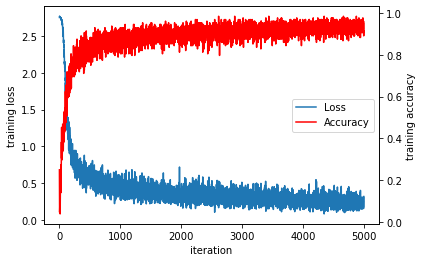

In [34]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

lns1 = ax1.plot(np.arange(train_steps), fig_loss, label="Loss")
lns2 = ax2.plot(np.arange(train_steps), fig_accuracy, 'r', label="Accuracy")

ax1.set_xlabel('iteration')
ax1.set_ylabel('training loss')
ax2.set_ylabel('training accuracy')

lns = lns1 + lns2
labels = ["Loss", "Accuracy"]

plt.legend(lns, labels, loc=7)
plt.show()

### 随机测试

In [12]:
import warnings
warnings.filterwarnings("ignore")

def predict(input_content):
    id_list = get_id_list(input_content)
    #  切割输入
    X = kr.preprocessing.sequence.pad_sequences([id_list], sequence_length)
    # 输入X数据，求图的data_10，即SoftMax层获得各分类概率矩阵Y
    Y = session.run(data_10, {X_holder:X})
    # 取概率矩阵中最大元素的索引为结果
    y = np.argmax(Y, axis = 1)
    # 第二大权重
    y_latent = np.argsort(np.max(Y, axis=0))[-2]
    # 解析结果
    label, label_latent = labelEncoder.inverse_transform(y)[0], labelEncoder.inverse_transform([y_latent])[0]
    return label, label_latent

In [16]:
selected_index = np.random.choice(test_index_1d_array, 1)[0]
selected_content = content_list[selected_index]
true_label = label_list[selected_index]
predict_label = predict(selected_content)

print("Selected text content: " + selected_content)
print("True label: " + true_label)
print("Predict label: " + predict_label[0])
print("Predict latent label: " + predict_label[1])

Selected text content: 新加坡国立大学：研制出在电池没电时仍可继续工作的智能芯片！ 微控制器,芯片,电池,NUS,新加坡国立大学 
True label: 科技
Predict label: 科技
Predict latent label: 金融


## 评估分析

### 混淆矩阵

In [52]:
from sklearn.metrics import confusion_matrix

def predict_test():
    startTime = time.time()
    test_sample_quantity = len(test_index_1d_array)
    batch_size = 100
    predict_Y_list = []
    
    for i in range(0, test_sample_quantity, batch_size):
        part_index_1d_array = test_index_1d_array[i: i + batch_size]
        batch_X = get_X(part_index_1d_array)
        predict_Y = session.run(data_10, {X_holder:batch_X})
        predict_Y_list.extend(predict_Y)
        usedTime = time.time() - startTime
        print_string = "{0} / {1} Cost time: {2:.2f} seconds.".format(i, test_sample_quantity, usedTime)
        print_flush(print_string)
    
    print_string = "{0} / {1} Cost time: {2:.2f} seconds.".format(test_sample_quantity, test_sample_quantity, usedTime)
    print_flush(print_string)
    
    Y = np.array(predict_Y_list)
    y = np.argmax(Y, axis=1)
    predict_label_list = labelEncoder.inverse_transform(y)
    
    return predict_label_list

test_label_list = [label_list[i] for i in test_index_1d_array]
predict_label_list = predict_test()

cm = pd.DataFrame(confusion_matrix(test_label_list, predict_label_list),
             columns = labelEncoder.classes_, index = labelEncoder.classes_)

if not os.path.isdir("./results/" + name_of_predictor):
    os.makedirs("./results/" + name_of_predictor)
cm.to_csv("./results/" + name_of_predictor + '/' + name_of_predictor + '_CNNTensor_CM.csv')

cm

,世界,体育,军事,农业,娱乐,房产,教育,文化,旅游,民生,汽车,游戏,疫情,科技,股票,金融
世界,5285,74,428,66,144,24,64,81,176,55,50,18,1,95,0,120
体育,48,8781,28,21,206,8,41,44,45,5,27,117,0,32,0,12
军事,350,24,5378,15,52,0,40,73,37,12,35,67,0,85,0,18
农业,19,8,11,4497,28,39,33,60,90,52,14,9,1,28,0,61
娱乐,51,85,71,47,8824,9,72,225,34,131,26,127,0,85,0,18
房产,14,4,0,59,8,4058,37,23,75,10,11,3,0,37,2,98
教育,44,37,28,65,65,15,6015,183,47,33,17,40,0,113,0,49
文化,53,11,32,85,193,15,120,6208,163,55,6,36,0,56,0,27
旅游,139,37,27,177,62,56,37,179,4538,23,68,23,0,53,1,33
民生,13,5,4,28,82,4,19,35,8,1343,9,8,0,5,0,5


### 报告表

In [37]:
from sklearn.metrics import precision_recall_fscore_support

def eval_model(y_true, y_pred, labels):
    # 计算每个分类的Precision, Recall, f1, support
    p, r, f1, s = precision_recall_fscore_support(y_true, y_pred)
    # 计算总体的平均Precision, Recall, f1, support
    tot_p = np.average(p, weights=s)
    tot_r = np.average(r, weights=s)
    tot_f1 = np.average(f1, weights=s)
    tot_s = np.sum(s)
    res1 = pd.DataFrame({
        u'Label': labels,
        u'Precision': p,
        u'Recall': r,
        u'F1': f1,
        u'Support': s
    })
    res2 = pd.DataFrame({
        u'Label': ['总体'],
        u'Precision': [tot_p],
        u'Recall': [tot_r],
        u'F1': [tot_f1],
        u'Support': [tot_s]
    })
    res2.index = [999]
    res = pd.concat([res1, res2])
    res.to_csv("./results/" + name_of_predictor + '/' + name_of_predictor + '_CNNTensor_PRFS.csv')
    return res[['Label', 'Precision', 'Recall', 'F1', 'Support']]

eval_model(test_label_list, predict_label_list, labelEncoder.classes_)

,Label,Precision,Recall,F1,Support
0,世界,0.847634,0.791049,0.818365,6681
1,体育,0.953524,0.932661,0.942977,9415
2,军事,0.871920,0.869382,0.870649,6186
3,农业,0.833859,0.908485,0.869574,4950
4,娱乐,0.882312,0.899949,0.891043,9805
5,房产,0.918100,0.914170,0.916130,4439
6,教育,0.891375,0.890979,0.891177,6751
7,文化,0.854861,0.879320,0.866918,7060
8,旅游,0.829768,0.832202,0.830983,5453
9,民生,0.751539,0.856505,0.800596,1568


## 复用

### 模型保存

不要随便乱点！！！！！！！！

In [43]:
saver = tf.train.Saver()
modelFilePath = "./" + name_of_predictor + "/trained_model/CNN_Tensorflow.ckpt"
saver.save(session, modelFilePath)

'./TouTiao/trained_model/CNN_Tensorflow.ckpt'

### 模型加载

In [11]:
saver = tf.train.Saver()
session = get_session()
modelFilePath = "./" + name_of_predictor + "/trained_model/CNN_Tensorflow.ckpt"
saver.restore(session, modelFilePath)

INFO:tensorflow:Restoring parameters from ./TouTiao/trained_model/CNN_Tensorflow.ckpt


## 应用预测

### 即时输入预测

In [17]:
input_content = """
孙杨案重审今日开庭：听证会为期三天，孙杨未要求开放公众
"""

print("Predict: " + predict(input_content)[0])
print("Latent predict: " + predict(input_content)[1])

Predict: 娱乐
Latent predict: 体育


### 新浪热搜即时预测

In [18]:
import requests

headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 11_0_0) '
                         'AppleWebKit/537.36 (KHTML, like Gecko) '
                         'Chrome/86.0.4240.198 Safari/537.36'}
html = requests.get('https://s.weibo.com/top/summary?cate=realtimehot', headers=headers)
page = html.content.decode()

res = re.findall(
    r'<tr class="">\s*<td class="td-01 ranktop">(\d+)<\/td>\s*<td class="td-02">\s*<a href="\/('
    r'.*?)&.*?target="_blank">(.*?)<\/a>', page, re.S)

# ind = [i[0] for i in res]
# link = ['https://s.weibo.com/' + i[1] for i in res]
title = [i[2] for i in res]
pred = [predict(t)[0] for t in title]
pred_latent = [predict(t)[1] for t in title]


dataFrame = pd.DataFrame({
        u'热搜标题': title,
        u'预测结果': pred,
        u'备用结果': pred_latent
    })
dataFrame.index = [i + 1 for i in range(50)]

dataFrame[['热搜标题', '预测结果', '备用结果']]
    

,热搜标题,预测结果,备用结果
1,彦希直播回应偷戒指,科技,娱乐
2,鸿蒙手机来了,科技,金融
3,白银马拉松事故救援幕后,世界,文化
4,甲沟炎,体育,农业
5,武汉的公交车有多夸张,汽车,旅游
6,老板请流浪汉吃水饺顾客偷偷买单,农业,世界
7,国台办表示愿迅速安排让台胞有疫苗用,农业,世界
8,iOS14.6,科技,汽车
9,印度或将遭遇第三轮疫情,疫情,世界
10,微博名后的小稻穗,农业,文化
